# 3D implant generation from skull scan (2D)

**Author:** Jonathan Keaveney<br>
**Date created:** 2021/06/14<br>
**Last modified:** 2021/07/06<br>
**Description:** Train a 3D convolutional neural network for prediction of crainial implant.

## Introduction

In this notebook a 3D convolutional neural network (CNN) is created to predict an implant shape suitable to replace missing crainial bone given computer tomography (CT) scans of damaged skulls.

## References

- ....

## Setup

## Downloading the [AutoImplant challenge MICCAI dataset](https://autoimplant.grand-challenge.org/Dataset/) 

Traing and test sets each consist of 100 data pairs of dimensions 512x512xZ, where Z is the number of axial slices
An additional 10 defective skulls, which have distinct (and more complicated) defects (in terms of defect shape, size and position etc) from those in the training and test set are laso provided.

In [1]:
def download_scans():
    
    # Make a directory to store the data.
    os.makedirs("TrainingData")    
                
    # Training Set
    url = "https://dl.dropboxusercontent.com/s/2v09h0vt0k3x9l3/training_set.zip?dl=0"
    filename = os.path.join(os.getcwd(), "training_set.zip")
    keras.utils.get_file(filename, url)
                
    # Unzip data in the newly created directory.
    with zipfile.ZipFile("training_set.zip", "r") as z_fp:
        z_fp.extractall("./TrainingData/")
    
    # Testing Set
    url = "https://dl.dropboxusercontent.com/s/me3yh4azub7jbpn/test_set_for_participants.zip?dl=0"
    filename = os.path.join(os.getcwd(), "test_set_for_participants.zip")
    keras.utils.get_file(filename, url)
  
    # Unzip data in the newly created directory.
    with zipfile.ZipFile("test_set_for_participants.zip", "r") as z_fp:
        z_fp.extractall("./TrainingData/")

    # 10 additional cases
    url = "https://dl.dropboxusercontent.com/s/7ijvewjw4lnjyjv/additional_test_set_for_participants.zip?dl=0"
    filename = os.path.join(os.getcwd(), "additional_test_set_for_participants.zip")
    keras.utils.get_file(filename, url)
   
    # Unzip data in the newly created directory.
    with zipfile.ZipFile("additional_test_set_for_participants.zip", "r") as z_fp:
        z_fp.extractall("./TrainingData/")
    

## Loading data and preprocessing

The files are provided in nrrd format with the extension .nrrd. To read the
scans, we use the `pynrrd` package.
You can install the package via `pip install pynrrd`. CT scans 3D voxel arrays of 0s and 1s.
Voxels of 0 are background and voxels of 1 are bone.

In [2]:
def read_nrrd_header(filepath):
    """Read header"""
    hd=nrrd.read_header(filepath)
    return hd

def read_nrrd_file(filepath):
    """Read and load volume"""
    data,hd=nrrd.read(filepath)
    # Get raw data
    #scan = scan.get_fdata()
    #data,hd=nrrd.read('C:/Users/jonathan.keaveney.ICONXSOLUTIONS/Documents/College/Modules/ED5005/Data/training_set/training_set/defective_skull/000.nrrd')
    return data


# def normalize(volume):
#     """Normalize the volume"""
#     min = -1000
#     max = 400
#     volume[volume < min] = min
#     volume[volume > max] = max
#     volume = (volume - min) / (max - min)
#     volume = volume.astype("float32")
#     return volume


# def resize_volume(img):
#     """Resize across z-axis"""
#     # Set the desired depth
#     desired_depth = 64
#     desired_width = 128
#     desired_height = 128
#     # Get current depth
#     current_depth = img.shape[-1]
#     current_width = img.shape[0]
#     current_height = img.shape[1]
#     # Compute depth factor
#     depth = current_depth / desired_depth
#     width = current_width / desired_width
#     height = current_height / desired_height
#     depth_factor = 1 / depth
#     width_factor = 1 / width
#     height_factor = 1 / height
#     # Rotate
#     img = ndimage.rotate(img, 90, reshape=False)
#     # Resize across z-axis
#     img = ndimage.zoom(img, (width_factor, height_factor, depth_factor), order=1)
#     return img

def resizing(label):
    a,b,c=label.shape
    resized_data = ndimage.zoom(label,(128/a,128/b,64/c),order=2, mode='constant')  
    return resized_data

def process_skull_scan(path):
    """Read and resize volume"""
    # Read scan
    volume = read_nrrd_file(path)
    # Normalize
    # volume = normalize(volume)
    # Resize width, height and depth
    #volume = resize_volume(volume)
    volume = resizing(volume)
    return volume


In [3]:
def load_training_data():
    # Folder "CT-0" consist of CT scans having normal lung tissue,
    # no CT-signs of viral pneumonia.
    normal_scan_paths = [
        os.path.join(os.getcwd(), "TrainingData/training_set/complete_skull", x)
        for x in os.listdir("TrainingData/training_set/complete_skull")
    ]
    # Folder "CT-23" consist of CT scans having several ground-glass opacifications,
    # involvement of lung parenchyma.
    abnormal_scan_paths = [
        os.path.join(os.getcwd(), "TrainingData/training_set/defective_skull", x)
        for x in os.listdir("TrainingData/training_set/defective_skull")
    ]

    return normal_scan_paths, abnormal_scan_paths

In [4]:
def load_test_data():
    # Folder "CT-0" consist of CT scans having normal lung tissue,
    # no CT-signs of viral pneumonia.
    test_scan_paths = [
        os.path.join(os.getcwd(), "TrainingData/test_set_for_participants", x)
        for x in os.listdir("TrainingData/test_set_for_participants")
    ]
    # Folder "CT-23" consist of CT scans having several ground-glass opacifications,
    # involvement of lung parenchyma.
    additional_test_scan_paths = [
        os.path.join(os.getcwd(), "TrainingData/additional_test_set_for_participants", x)
        for x in os.listdir("TrainingData/additional_test_set_for_participants")
    ]
    
    return test_scan_paths, additional_test_scan_paths

Let's read the paths of the CT scans from the class directories.

## Build train and validation datasets
Read the scans from the class directories and assign labels. Downsample the scans to have
shape of 128x128x64. And, split the dataset into train and validation subsets.

In [5]:
import nrrd
import os
import zipfile
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import random

from scipy import ndimage
from tensorflow import keras
from tensorflow.keras import layers
from scipy import ndimage
# read file headers
#[print(path + ': ' + str(read_nrrd_header(path)['sizes'])) for path in abnormal_scan_paths]
#[read_nrrd_header(path) for path in normal_scan_paths]
normal_scan_paths, abnormal_scan_paths = load_training_data()
#print(normal_scan_paths)
normal_scans = np.array([process_skull_scan(path) for path in normal_scan_paths[0:4]])
zero_layer = np.expand_dims(np.where(normal_scans==0,1,0), axis=4)
one_layer = np.expand_dims(np.where(normal_scans==1,1,0), axis=4)
#128, 128, 64, 2
result = np.concatenate((zero_layer, one_layer), axis=4)
print(zero_layer.shape)
print(result.shape)

(4, 128, 128, 64, 1)
(4, 128, 128, 64, 2)


In [44]:
# two options have label as (None, 128, 128, 64, 2) and prediction as (70, 128, 128, 64, 2) also
# or have label as (None, 128, 128, 64) and prediction as (None, 128, 128, 64, 2) and use y_pred = tf.math.argmax(y_pred, axis=-1) in loss function
## try both
option = 2

def dice_loss2(y_pred, y_true): #(70, 128, 128, 64) (70, 128, 128, 64, 2)
    y_true = tf.cast(y_true, tf.float32)
    
    #y_true, y_pred - [?,128,128,64,2]
    #y_pred, y_true - [?,128,128,64,2].
    
    if(option == 2):
        y_pred = tf.math.argmax(y_pred, axis=-1)
        
    y_pred = tf.cast(y_pred, tf.float32)
    y_pred = tf.math.sigmoid(y_pred)
    numerator = 2 * tf.reduce_sum(y_true * y_pred)
    denominator = tf.reduce_sum(y_true + y_pred)

    return 1 - numerator / denominator
#     y_true = tf.cast(y_true, tf.float32)
#     y_pred = tf.cast(y_pred, tf.float32)
#     squared_difference = tf.square(y_true - y_pred)
#     return tf.reduce_mean(squared_difference, axis=-1)  # Note the `axis=-1`

In [45]:
#prediction = np.argmax(prediction, axis=-1) 
print(np.expand_dims(normal_scans[0], axis=0).shape)
print(np.expand_dims(result[0], axis=0).shape)
dice_loss2(np.expand_dims(result[0], axis=0),np.expand_dims(normal_scans[0], axis=0))

#[?,128,128,64,2], [?,128,128,64,1,2]

#[?,128,128,64,1,2], [?,128,128,64].
#[?,128,128,64,1,2], [128,128,64]
#[?,128,128,64,2], [?,128,128,64].
#[?,128,128,64,2], [?,128,128,64].

(1, 128, 128, 64)
(1, 128, 128, 64, 2)


<tf.Tensor: shape=(), dtype=float32, numpy=0.8614683>

In [10]:
dice_loss2(normal_scans[0].astype('float32'),result[0].astype('float32'))

InvalidArgumentError: Incompatible shapes: [128,128,64,2] vs. [128,128] [Op:Mul]

In [11]:
print(x_train.shape)
print(y_train.shape)
print(x_val.shape)
print(y_val.shape)

NameError: name 'x_train' is not defined

In [ ]:
def build_dataset_and_train_test_split(train_size, normal_scan_paths, abnormal_scan_paths):
    normal_scans = np.array([process_skull_scan(path) for path in normal_scan_paths])
    abnormal_scans = np.array([process_skull_scan(path) for path in abnormal_scan_paths])
    
    # split
    x_train = abnormal_scans[:train_size]
    
    
    if(option == 1):
        y_train = normal_scans[:train_size]
    else:
        #128, 128, 64, 2
        zero_layer = np.expand_dims(np.where(normal_scans[:train_size]==0,1,0), axis=4)
        one_layer = np.expand_dims(np.where(normal_scans[:train_size]==1,1,0), axis=4)
        y_train = np.concatenate((zero_layer, one_layer), axis=4)
    
    x_val = abnormal_scans[train_size:]
    if(option == 1):
        y_val = normal_scans[train_size:]
    else:
        #128, 128, 64, 2
        zero_layer = np.expand_dims(np.where(normal_scans[train_size:]==0,1,0), axis=4)
        one_layer = np.expand_dims(np.where(normal_scans[train_size:]==1,1,0), axis=4)
        y_val = np.concatenate((zero_layer, one_layer), axis=4)
    
    return x_train, y_train, x_val, y_val


## Data augmentation

The CT scans also augmented by rotating at random angles during training. Since
the data is stored in rank-3 tensors of shape `(samples, height, width, depth)`,
we add a dimension of size 1 at axis 4 to be able to perform 3D convolutions on
the data. The new shape is thus `(samples, height, width, depth, 1)`. There are
different kinds of preprocessing and augmentation techniques out there,
this example shows a few simple ones to get started.

While defining the train and validation data loader, the training data is passed through
and augmentation function which randomly rotates volume at different angles. Note that both
training and validation data are already rescaled to have values between 0 and 1.

In [30]:
def define_data_loaders(batch_size):
    
    @tf.function
    def rotate(volume, label):
        """Rotate the volume by a few degrees"""

        angles = [-20, -10, -5, 5, 10, 20]
        # pick angles at random
        angle = random.choice(angles)
        
        def scipy_rotate_volumn(volume):
            # define some rotation angles
            
            # rotate volume
            volume = ndimage.rotate(volume, angle, reshape=False)
            volume[volume < 0] = 0
            volume[volume > 1] = 1
            return volume
        
        def scipy_rotate_label(label):
            # define some rotation angles
            
            # rotate volume
            label = ndimage.rotate(label, angle, reshape=False)
            label[label < 0] = 0
            label[label > 1] = 1
            return label

        augmented_volume = tf.numpy_function(scipy_rotate_volumn, [volume], tf.int32)
        augmented_label = tf.numpy_function(scipy_rotate_label, [label], tf.int32)
        
        return augmented_volume, augmented_label


    def train_preprocessing(volume, label):
        """Process training data by rotating and adding a channel."""
        # Rotate volume
        #volume, label = rotate(volume, label)
        volume = tf.expand_dims(volume, axis=3)
        if(option == 2):
            label = tf.expand_dims(label, axis=3)
        return volume, label


    def validation_preprocessing(volume, label):
        """Process validation data by only adding a channel."""
        volume = tf.expand_dims(volume, axis=3)
        if(option == 2):
            label = tf.expand_dims(label, axis=3)
        return volume, label
    
    train_loader = tf.data.Dataset.from_tensor_slices((x_train, y_train))
    validation_loader = tf.data.Dataset.from_tensor_slices((x_val, y_val))

    # Augment the on the fly during training.
    train_dataset = (
        train_loader.shuffle(len(x_train))
        .map(train_preprocessing)
        .batch(batch_size)
        .prefetch(2)
    )
    # Only rescale.
    validation_dataset = (
        validation_loader.shuffle(len(x_val))
        .map(validation_preprocessing)
        .batch(batch_size)
        .prefetch(2)
    )
    
    return train_dataset, validation_dataset

Visualize an augmented CT scan.

In [31]:
def visualize_augmented_ct_scan(data):
    images, labels = list(data)[0]
    images = images.numpy()
    image = images[0]
    print("Dimension of the CT scan is:", image.shape)
    plt.imshow(np.squeeze(image[:, :,30]), cmap="gray")
    #plt.imshow(np.squeeze(image[:, :,40]), cmap="gray")
    #plt.imshow(np.squeeze(image[:, :,50]), cmap="gray")
    #plt.imshow(np.squeeze(image[:, :,60]), cmap="gray")


Since a CT scan has many slices, let's visualize a montage of the slices.

In [32]:

def plot_slices(num_rows, num_columns, width, height, data):
    """Plot a montage of 20 CT slices"""
    data = np.rot90(np.array(data))
    data = np.transpose(data)
    data = np.reshape(data, (num_rows, num_columns, width, height))
    rows_data, columns_data = data.shape[0], data.shape[1]
    heights = [slc[0].shape[0] for slc in data]
    widths = [slc.shape[1] for slc in data[0]]
    fig_width = 12.0
    fig_height = fig_width * sum(heights) / sum(widths)
    f, axarr = plt.subplots(
        rows_data,
        columns_data,
        figsize=(fig_width, fig_height),
        gridspec_kw={"height_ratios": heights},
    )
    for i in range(rows_data):
        for j in range(columns_data):
            axarr[i, j].imshow(data[i][j], cmap="gray")
            axarr[i, j].axis("off")
    plt.subplots_adjust(wspace=0, hspace=0, left=0, right=1, bottom=0, top=1)
    plt.show()


## Define a 3D convolutional neural network

To make the model easier to understand, we structure it into blocks.
The architecture of the 3D CNN used in this example
is based on [this paper](https://arxiv.org/abs/2007.13224).

In [33]:
def get_unet(width=128, height=128, depth=64):
    """Build a 3D convolutional neural network model."""

    inputs = keras.Input((width, height, depth, 1))
    filtersValue=16

    conv1 = layers.Conv3D(filtersValue, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(inputs)
    conv1 = layers.Conv3D(filtersValue, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv1)
    pool1 = layers.MaxPool3D(pool_size=(2, 2, 2))(conv1)
    conv2 = layers.Conv3D(filtersValue*2, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool1)
    conv2 = layers.Conv3D(filtersValue*2, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv2)
    pool2 = layers.MaxPool3D(pool_size=(2, 2, 2))(conv2)
    conv3 = layers.Conv3D(filtersValue*4, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool2)
    conv3 = layers.Conv3D(filtersValue*4, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv3)
    pool3 = layers.MaxPool3D(pool_size=(2, 2, 2))(conv3)
    conv4 = layers.Conv3D(filtersValue*8, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool3)
    conv4 = layers.Conv3D(filtersValue*8, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv4)
    drop4 = layers.Dropout(0.5)(conv4)
    pool4 = layers.MaxPool3D(pool_size=(2, 2, 2))(drop4)

    conv5 = layers.Conv3D(filtersValue*16, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool4)
    conv5 = layers.Conv3D(filtersValue*16, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv5)
    drop5 = layers.Dropout(0.5)(conv5)

    up6 = layers.Conv3D(filtersValue*8, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(layers.UpSampling3D(size = (2,2,2))(drop5))
    merge6 = layers.concatenate([drop4,up6], axis = 4)
    conv6 = layers.Conv3D(filtersValue*8, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge6)
    conv6 = layers.Conv3D(filtersValue*8, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv6)

    up7 = layers.Conv3D(filtersValue*4, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(layers.UpSampling3D(size = (2,2,2))(conv6))
    merge7 = layers.concatenate([conv3,up7], axis = 4)
    conv7 = layers.Conv3D(filtersValue*4, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge7)
    conv7 = layers.Conv3D(filtersValue*4, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv7)

    up8 = layers.Conv3D(filtersValue*2, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(layers.UpSampling3D(size = (2,2,2))(conv7))
    merge8 = layers.concatenate([conv2,up8], axis = 4)
    conv8 = layers.Conv3D(filtersValue*2, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge8)
    conv8 = layers.Conv3D(filtersValue*2, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv8)

    up9 = layers.Conv3D(filtersValue, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(layers.UpSampling3D(size = (2,2,2))(conv8))
    merge9 = layers.concatenate([conv1,up9], axis = 4)
    conv9 = layers.Conv3D(filtersValue, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge9)
    conv9 = layers.Conv3D(filtersValue, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv9)
    #conv9 = layers.Conv3D(2, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv9)
    #out = layers.Conv3D(1, 3, activation = 'sigmoid', padding = 'same')(conv9)
    
    # Add a per-pixel classification layer
    num_classes = 2 # classes are 1s or 0s
    out = layers.Conv3D(num_classes, 3, activation="softmax", padding="same")(conv9)

    model = keras.Model(inputs = inputs, outputs = out, name="3dcnn")
    #model.compile(optimizer = "sgd", loss = 'binary_crossentropy', metrics = ['accuracy'])

    return model

# output layer is float but label image is 1s and 0s. there is some info on converting the output to integers here
# https://github.com/keras-team/keras/issues/2218


Define a suitable loss function

In [34]:
def dice_loss(y_true, y_pred):
    y_true = tf.cast(y_true, tf.float32)
    y_pred = tf.math.sigmoid(y_pred)
    numerator = 2 * tf.reduce_sum(y_true * y_pred)
    denominator = tf.reduce_sum(y_true + y_pred)

    return 1 - numerator / denominator

## Train model

First load data

In [36]:
#!pip install nibabel
#!pip install matplotlib
#!pip install pynrrd

#import nibabel as nib
import nrrd
import os
import zipfile
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import random

from scipy import ndimage
from tensorflow import keras
from tensorflow.keras import layers
from scipy import ndimage


#download_scans()
normal_scan_paths, abnormal_scan_paths = load_training_data()
print("CT scans with normal skull: " + str(len(normal_scan_paths)))
print("CT scans with defective skull: " + str(len(abnormal_scan_paths)))

# test_scan_paths, additional_test_scan_paths = load_test_data()
# print("CT scans with normal skull: " + str(len(normal_scan_paths)))
# print("CT scans with defective skull: " + str(len(abnormal_scan_paths)))

x_train, y_train, x_val, y_val = build_dataset_and_train_test_split(70, normal_scan_paths, abnormal_scan_paths)
    
print(
    "Number of samples in train and validation are %d and %d."
    % (x_train.shape[0], x_val.shape[0])
)

train_dataset, validation_dataset = define_data_loaders(2)
    

CT scans with normal skull: 100
CT scans with defective skull: 100
Number of samples in train and validation are 70 and 30.


In [19]:
train_dataset, validation_dataset = define_data_loaders(2)

In [37]:
print(x_train.shape)
print(y_train.shape)
print(x_val.shape)
print(y_val.shape)

(70, 128, 128, 64)
(70, 128, 128, 64)
(30, 128, 128, 64)
(30, 128, 128, 64)


In [21]:
print(x_train.shape)
print(y_train.shape)
print(x_val.shape)
print(y_val.shape)

(70, 128, 128, 64)
(70, 128, 128, 64, 2)
(30, 128, 128, 64)
(30, 128, 128, 64, 2)


Build and train model

In [38]:
# Build model.
model = get_unet(width=128, height=128, depth=64)
model.summary(line_length=150)

# Defin data loaders
train_dataset, validation_dataset = define_data_loaders(1)

# Compile model.
initial_learning_rate = 0.0001
lr_schedule = keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate, decay_steps=100000, decay_rate=0.96, staircase=True
)
model.compile(
    #loss="binary_crossentropy",
    #loss=dice_loss,
    loss=dice_loss2,
    #loss="sparse_categorical_crossentropy",
    #loss="categorical_crossentropy",
    optimizer=keras.optimizers.Adam(learning_rate=lr_schedule),
    metrics=["acc"],
)

# Define callbacks.
checkpoint_cb = keras.callbacks.ModelCheckpoint(
    "3d_implant_generation004.h5", save_best_only=True
)
early_stopping_cb = keras.callbacks.EarlyStopping(monitor="val_acc", patience=15)

# Train the model, doing validation at the end of each epoch
epochs = 4
model.fit(
    train_dataset,
    validation_data=validation_dataset,
    epochs=epochs,
    shuffle=True,
    verbose=2,
    callbacks=[checkpoint_cb, early_stopping_cb],
)


Model: "3dcnn"
______________________________________________________________________________________________________________________________________________________
Layer (type)                                     Output Shape                     Param #           Connected to                                      
input_3 (InputLayer)                             [(None, 128, 128, 64, 1)]        0                                                                   
______________________________________________________________________________________________________________________________________________________
conv3d_46 (Conv3D)                               (None, 128, 128, 64, 16)         448               input_3[0][0]                                     
______________________________________________________________________________________________________________________________________________________
conv3d_47 (Conv3D)                               (None, 128, 128, 64, 16)      

It is important to note that the number of samples is very small (only 200) and we don't
specify a random seed. As such, you can expect significant variance in the results. The full dataset
which consists of over 1000 CT scans can be found [here](https://www.medrxiv.org/content/10.1101/2020.05.20.20100362v1). Using the full
dataset, an accuracy of 83% was achieved. A variability of 6-7% in the classification
performance is observed in both cases.

## Visualizing model performance

Here the model accuracy and loss for the training and the validation sets are plotted.
Since the validation set is class-balanced, accuracy provides an unbiased representation
of the model's performance.

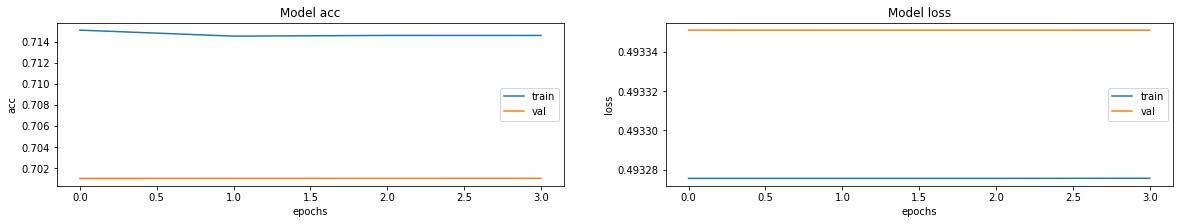

In [40]:
fig, ax = plt.subplots(1, 2, figsize=(20, 3))
ax = ax.ravel()

for i, metric in enumerate(["acc", "loss"]):
    ax[i].plot(model.history.history[metric])
    ax[i].plot(model.history.history["val_" + metric])
    ax[i].set_title("Model {}".format(metric))
    ax[i].set_xlabel("epochs")
    ax[i].set_ylabel(metric)
    ax[i].legend(["train", "val"])

## Document results - average DSC

In [37]:
model.evaluate(np.expand_dims(abnormal_scans[3], axis=0), np.expand_dims(normal_scans[3], axis=0))

1/1 [==============================] - 0s 390ms/step - loss: 0.8628 - acc: 0.9817


[0.8627868890762329, 0.9817333221435547]

In [46]:
#model.load_weights("3d_implant_generation003.h5")

dice_loss_scores = []
for i in range(y_val.shape[0]):
    prediction = model.predict(np.expand_dims(x_val[i], axis=0))[0]
    #prediction = np.argmax(prediction, axis=-1)
    #mask = np.expand_dims(mask, axis=-1)
    y_pred = prediction[:,:,:,0] #np.argmax(, axis=-1)
    y_true = np.argmax(y_val[i], axis=-1).astype('float32')
#     print(y_pred.shape)
#     print(y_true.shape)
#     break;
    dice_loss_scores.append(dice_loss2(y_pred,y_true).numpy())

print(sum(dice_loss_scores) / len(dice_loss_scores))


-0.03689478437105815


In [34]:
print(model.predict(np.expand_dims(x_val[0], axis=0))[0].shape)
print(y_val[i].shape)

(128, 128, 64, 2)
(128, 128, 64, 2)


In [39]:
print(np.argmax(model.predict(np.expand_dims(x_val[0], axis=0))[0], axis=-1).shape)
print(np.argmax(y_val[i], axis=-1).shape)

(128, 128, 64)
(128, 128, 64)


#### Log results for various experiments

dsc = 0.8606623848279317 for filtersValue=8 (1.4 million paramaters)

dsc = 0.8798759043216705 for filtersValue=16 (5.6 million paramaters)

dsc = 0.881765220562617 for filtersValue=16 (5.6 million paramaters) with random rotations in training

dsc = 0.8588505566120148 for filtersValue=16 (5.6 million paramaters) with random rotations in training and batch size of 4

dsc = 0.8834250112374623 for filtersValue=16 (5.6 million paramaters) with random rotations in training and batch size of 1

dsc = 0.8837966521581014 for filtersValue=32 (22.5 million paramaters) with random rotations in training and batch size of 1


# Visualise Prediction

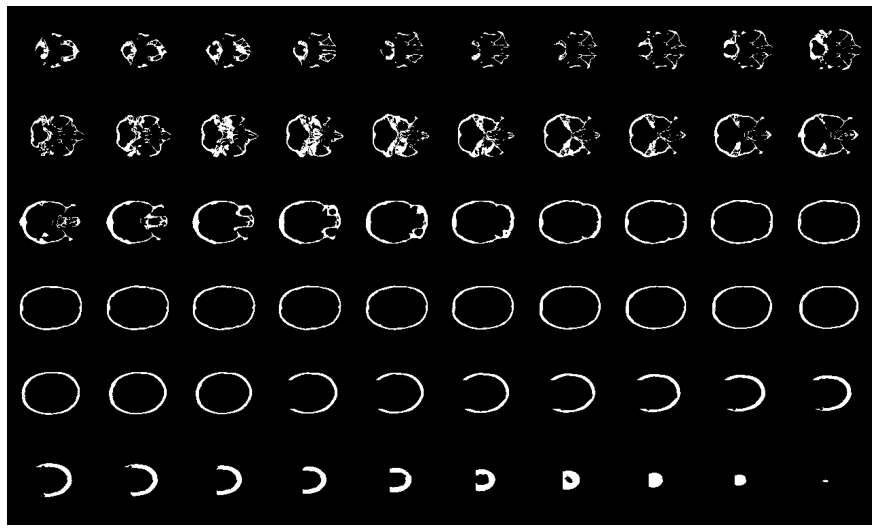

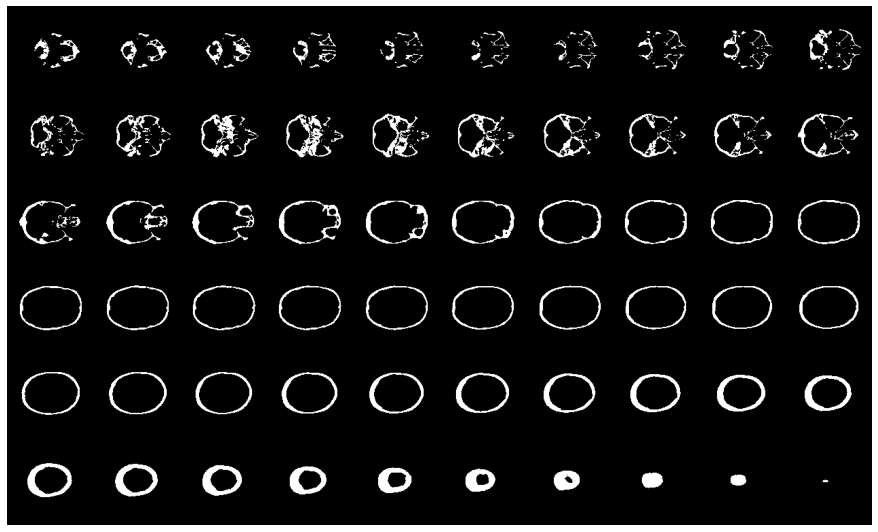

In [21]:
plot_slices(6, 10, 128, 128,x_val[3][:, :, :60])
p=model.predict(np.expand_dims(x_val[3], axis=0))[0]
plot_slices(6, 10, 128, 128,np.where(p>0.5,1,0)[:, :, :60])
# visualize_augmented_ct_scan(train_dataset.take(1)):
# # Visualize montage of slices.
# # 4 rows and 10 columns for 100 slices of the CT scan.
# plot_slices(6, 10, 128, 128, x_train[0][:, :, :60])
# plot_slices(6, 10, 128, 128, y_train[0][:, :, :60])

# Save Prediction To nrrd

In [24]:
# Load best weights.
model.load_weights("3d_implant_generation004.h5")
#prediction = model.predict(np.expand_dims(x_val[0], axis=0))[0]

prediction = model.predict(np.expand_dims(x_val[3], axis=0))[0]
#prediction = model.predict(np.expand_dims(normal_scans[0], axis=0))[0]
prediction.shape

filename = os.path.join(os.getcwd(), "prediction5.nrrd")
nrrd.write(filename, np.where(prediction>0.5,1,0)[:,:,:,0])
#np.where(p>0.9999,1,0)

# header = {'kinds': ['domain', 'domain', 'domain'], 'units': ['mm', 'mm', 'mm'], 'spacings': [1.0458, 1.0458, 2.5], 'space': 'right-anterior-superior', 'space directions': np.array([[1, 0, 0], [0, 1, 0], [0, 0, 1]]), 'encoding': 'ASCII', 'custom_field_here1': 24.34, 'custom_field_here2': np.array([1, 2, 3, 4])}
# custom_field_map = {'custom_field_here1': 'double', 'custom_field_here2': 'int list'}
# header = {'kinds': ['domain', 'domain', 'domain'], 'units': ['mm', 'mm', 'mm'], 'spacings': [1.0458, 1.0458, 2.5], 'space': 'right-anterior-superior', 'space directions': np.array([[1, 0, 0], [0, 1, 0], [0, 0, 1]]), 'encoding': 'ASCII', 'custom_field_here1': 24.34, 'custom_field_here2': np.array([1, 2, 3, 4])}
# custom_field_map = {'custom_field_here1': 'double', 'custom_field_here2': 'int list'}
# nrrd.write(filename, data, header, custom_field_map=custom_field_map)

# scores = [1 - prediction[0], prediction[0]]

# class_names = ["normal", "abnormal"]
# for score, name in zip(scores, class_names):
#     print(
#         "This model is %.2f percent confident that CT scan is %s"
#         % ((100 * score), name)
#     )

In [18]:
model.load_weights("3d_implant_generation004.h5")
#prediction = model.predict(np.expand_dims(x_val[0], axis=0))[0]

prediction = model.predict(np.expand_dims(abnormal_scans[3], axis=0))[0]
data = validation_dataset.take(1)
images, labels = list(data)[0]
images = images.numpy()
image = images[0]
print("Dimension of the CT scan is:", image.shape)
plt.imshow(np.squeeze(image[:, :,30]), cmap="gray")

NameError: name 'validation_dataset' is not defined

## Interpreate Prediction

In [35]:
data,hd=nrrd.read('./TrainingData/training_set/complete_skull/000.nrrd')
print(hd)

OrderedDict([('type', 'int32'), ('dimension', 3), ('space', 'left-posterior-superior'), ('sizes', array([512, 512, 237])), ('space directions', array([[ 0.451172  ,  0.        ,  0.        ],
       [ 0.        ,  0.44561735, -0.07057867],
       [ 0.        ,  0.09902267,  0.62520619]])), ('kinds', ['domain', 'domain', 'domain']), ('endian', 'little'), ('encoding', 'gzip'), ('space origin', array([-120.2       , -127.84611718,  -10.21586356]))])


In [68]:
data,hd=nrrd.read('prediction3.nrrd')
print(hd)

OrderedDict([('type', 'float'), ('dimension', 3), ('sizes', array([128, 128,  64])), ('endian', 'little'), ('encoding', 'gzip')])


In [65]:
np.where(prediction[:,:,:,0] > 0.1, 1, 0).shape

(128, 128, 64)

In [69]:
#print(np.unique(np.where(data > 0.1, 1, 0)))
print(np.unique(data))

[0.0000000e+00 1.1759482e-38 1.1763609e-38 ... 9.9999982e-01 9.9999988e-01
 1.0000000e+00]


In [70]:
np.histogram(data)
#np.histogram(data)

(array([968075,   2546,   1599,   1252,   1182,   1220,   1265,   1526,
          2221,  67690]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ],
       dtype=float32))